# Object Detection Example
## onnx model by YOLOv5m

In [1]:
import onnxruntime as ort 
import matplotlib.pyplot as plt
import torchvision.transforms as trns
from PIL import Image
import time
import numpy as np
import warnings
import torch
import torchvision
import cv2
warnings.simplefilter("ignore")



# Define image transforms
transforms = trns.Compose([trns.Resize((640, 640)), trns.ToTensor()])
# transforms = trns.Compose([trns.Resize((224, 224)), trns.ToTensor(), trns.Normalize(
#     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

onnxmodel_path='./yolov5m.onnx'
image_paths = ['images/Car.jpg',
              'images/cat.jpg',
              'images/Cruise-ships-1.png',
              'images/people1.jpg',
               'images/sheep1.jpeg',
              'images/horse.jpg']
class_def = 'coco.names'

# Load MSCOCO classes
with open(class_def) as f:
    classesname = [line.strip() for line in f.readlines()]
print(classesname[:3])
# Run the model on the backend
session = ort.InferenceSession(onnxmodel_path)
# get the name of the first input of the model
input_name = session.get_inputs()[0].name  
output_name = [tmp.name for tmp in session.get_outputs()]
print('Input Name:', input_name)
print('Output Name:', output_name)



In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

['person', 'bicycle', 'car']
Input Name: images
Output Name: ['output', '524', '585', '646']


# NMS function


In [2]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """
    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates
    

#     # Checks
#     assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
#     assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
#     output = [torch.zeros((prediction.shape[1], 6), device=prediction.device)] * prediction.shape[0]
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])
        
        
        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

            
            
        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
 
            
        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence
        
        
        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy
        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output


In [3]:
conf=0.15  # confidence threshold
iou=0.6 # NMS IOU threshold
classes = 80
max_det = 100
cuda = 0
device = torch.device('cuda:0' if cuda else 'cpu')
agnostic_nms=False
for i, image_path in enumerate(image_paths):
    print('********')
    print(image_path)
    # Read image and run prepro
    image = Image.open(image_path).convert("RGB")
    ori_w,ori_h=image.size
    
    image_tensor = transforms(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_np = image_tensor.numpy()

    outputs = session.run([session.get_outputs()[0].name], {session.get_inputs()[0].name: image_np})[0]
    outputs = torch.tensor(outputs)
    print("Output size:{}".format(outputs.shape))
    pred = non_max_suppression(outputs, conf_thres=conf, iou_thres=iou,  agnostic=agnostic_nms, max_det=max_det)
   

#     print(pred[0].shape)#  list of detections, on (n,6) tensor per image [xyxy, conf, cls]
#     print(pred[0])#  list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    
    
    img_cv = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    for box in pred[0]:
        x_min = int(box[0]/640*ori_w)
        y_min = int(box[1]/640*ori_h)
        x_max = int(box[2]/640*ori_w)
        y_max = int(box[3]/640*ori_h)
        conf = box[4]
        cls = int(box[5])
        cv2.rectangle(img_cv, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img_cv, '{},s={:.2f}'.format(classesname[cls],conf), (x_min, y_min+10), cv2.FONT_HERSHEY_TRIPLEX,1, (255, 125, 0), 1, cv2.LINE_AA)
    image_path
    cv2.imwrite('result_{}.jpg'.format(i), img_cv)
#     break
    

#     outputs = session.run(output_name, {input_name: image_np}) 
#     print(outputs[0].shape)
#     print(outputs[1].shape)
#     print(outputs[2].shape)
#     print(outputs[3].shape)

********
images/Car.jpg
Output size:torch.Size([1, 25200, 85])
********
images/cat.jpg
Output size:torch.Size([1, 25200, 85])
********
images/Cruise-ships-1.png
Output size:torch.Size([1, 25200, 85])
********
images/people1.jpg
Output size:torch.Size([1, 25200, 85])
********
images/sheep1.jpeg
Output size:torch.Size([1, 25200, 85])
********
images/horse.jpg
Output size:torch.Size([1, 25200, 85])


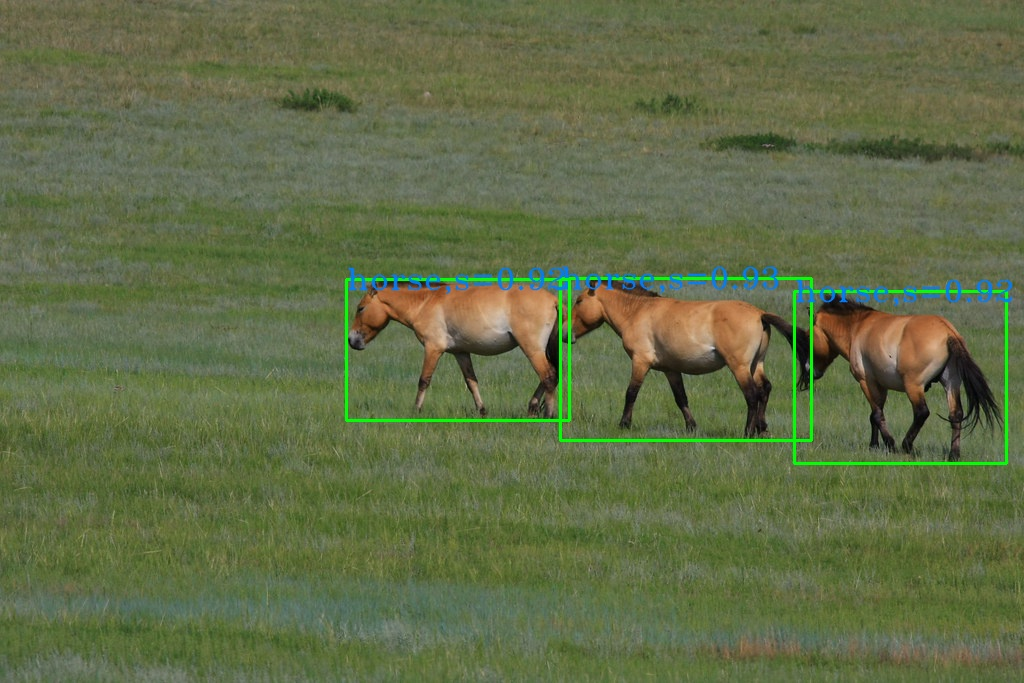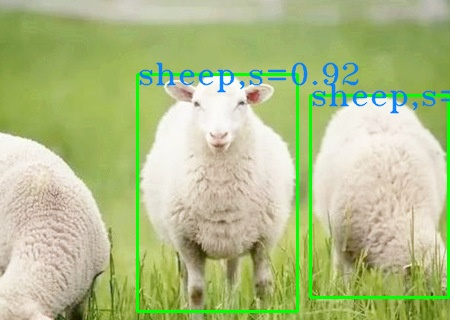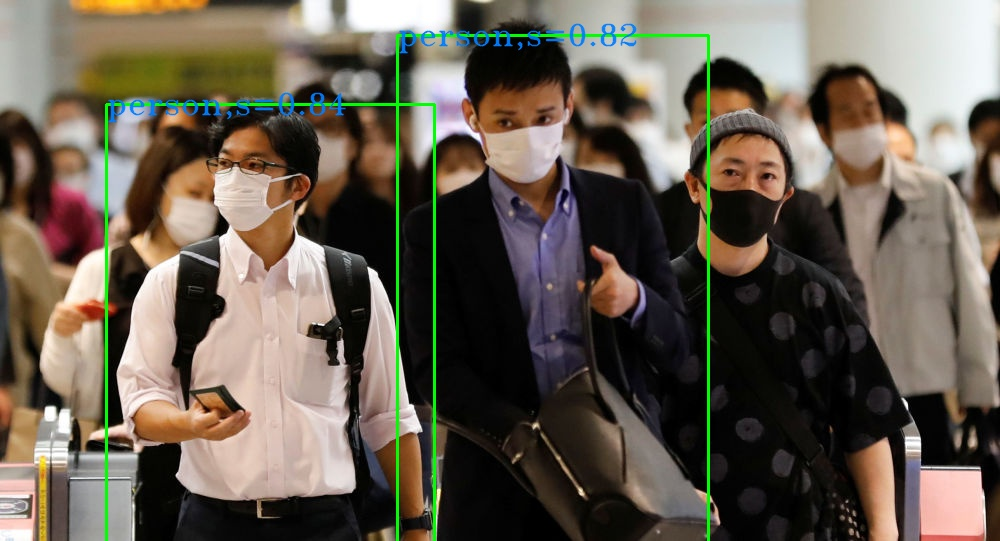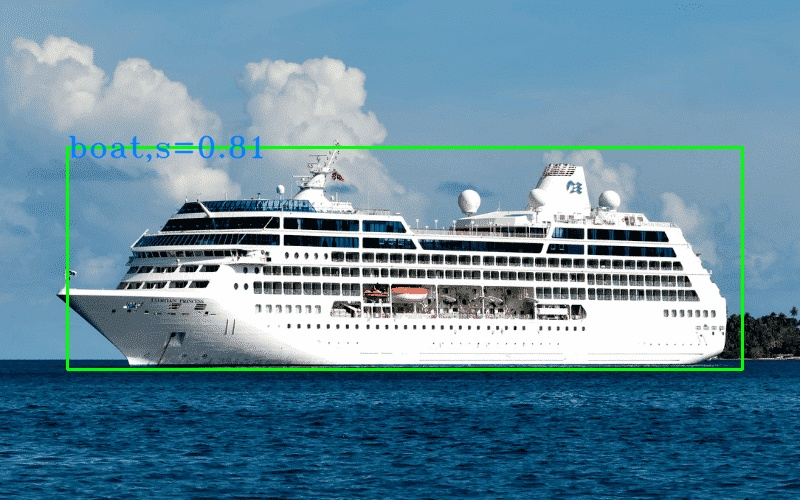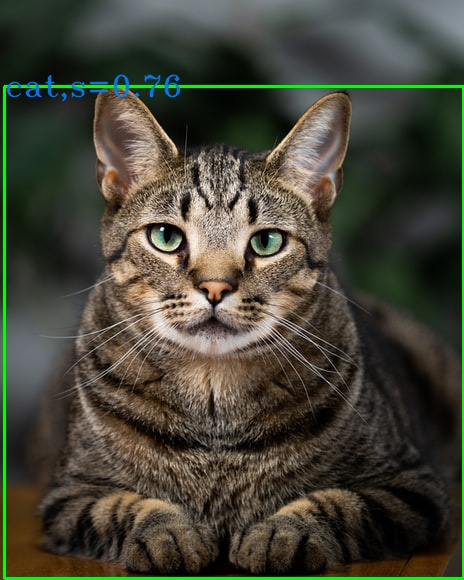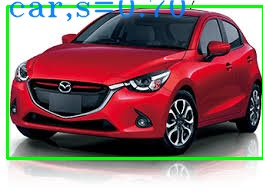